In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
import random
from sklearn.svm import SVC
random.seed(189)
np.random.seed(189)


In [2]:
#q1
def contrast_normalize(images):
    l2_norms = np.linalg.norm(images, ord=2, axis=1, keepdims=True)
    l2_norms[l2_norms == 0] = 1e-10 
    normalized_images = images / l2_norms
    return normalized_images

mnist_data = np.load("../data/mnist-data-hw3.npz")
training_data, training_labels = mnist_data["training_data"].reshape(-1, 28 * 28), mnist_data["training_labels"]
test_data = mnist_data["test_data"].reshape(-1, 28 * 28)

#normalize
training_data = contrast_normalize(training_data)
test_data = contrast_normalize(test_data)
digit_classes = np.unique(training_labels)

digit_data = {digit: training_data[training_labels == digit] for digit in digit_classes}
means = {}
cov = {}
 
for digit, x in digit_data.items():
    means[digit] = np.mean(x, axis=0)
    cov[digit] = np.cov(x, rowvar=False)

for digit in set(training_labels):
    print(f"Digit: {digit}")
    print("Mean vector shape:", means[digit].shape)
    print("Covariance matrix shape:", cov[digit].shape)



Digit: 0
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 1
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 2
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 3
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 4
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 5
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 6
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 7
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 8
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)
Digit: 9
Mean vector shape: (784,)
Covariance matrix shape: (784, 784)


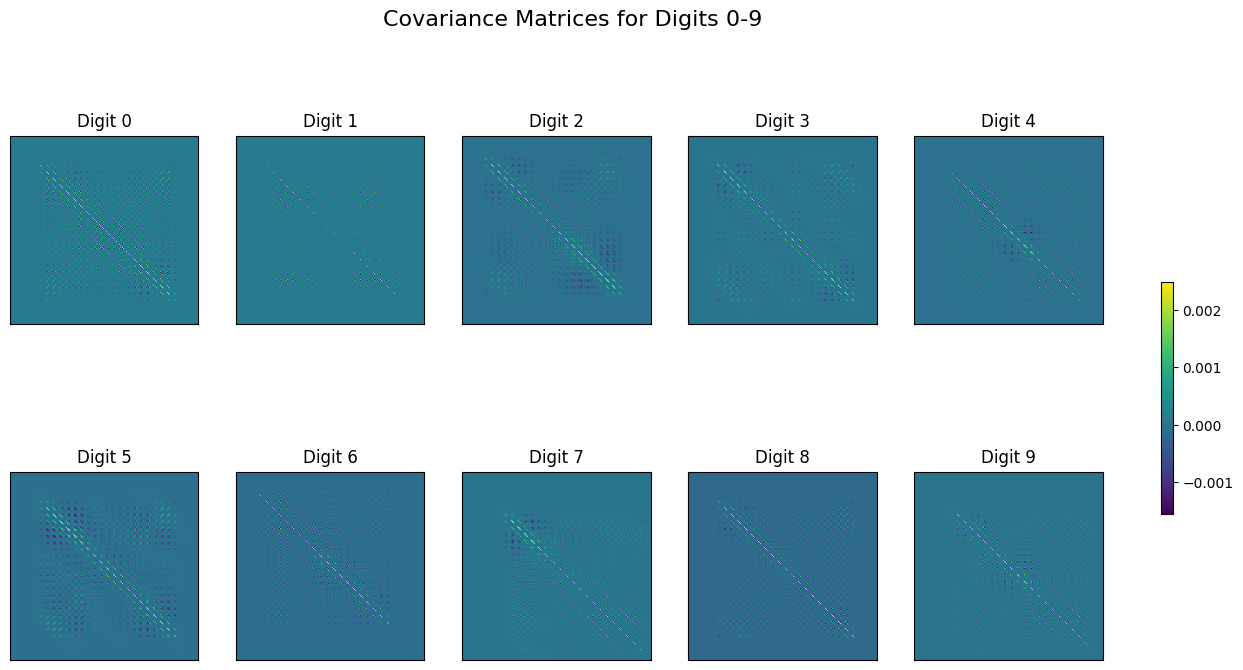

In [3]:
#q2
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, digit in enumerate(digit_classes):
    ax = axes[i // 5, i % 5]
    cov_matrix = cov[digit]
    im = ax.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    ax.set_title(f"Digit {digit}")
    ax.set_xticks([])
    ax.set_yticks([])

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.01)
plt.suptitle("Covariance Matrices for Digits 0-9", fontsize=16)
plt.show()


In [ ]:
#part 3
def shuffle_partition_MNIST(data):
    training_data = data["training_data"].reshape(-1, 28 * 28)
    training_labels = data["training_labels"].reshape(-1, 1)
    combined_data = np.hstack((training_data, training_labels))

    np.random.shuffle(combined_data)
    validation_data = combined_data[:10000, :-1]  
    validation_labels = combined_data[:10000, -1]  
    training_data = combined_data[10000:, :-1]  
    training_labels = combined_data[10000:, -1]  

    return validation_data, validation_labels, training_data, training_labels

def train_lda(data, label):
    classes = np.unique(label)
    n, d = data.shape

    pi_c = np.zeros(len(classes))
    mu_c = np.zeros((len(classes), d))
    Sigma = np.zeros((d, d))

    for i, c in enumerate(classes):
        num_samples = data[label == c]
        pi_c[i] = len(num_samples) / n
        mu_c[i] = np.mean(num_samples, axis=0)

    for i, c in enumerate(classes):
        num_samples = data[np.where(label == c)]
        diff = num_samples - mu_c[i]
        Sigma += diff.T @ diff  

    Sigma /= n  

    return pi_c, mu_c, Sigma, classes

def predict_lda(data, pi_c, mu_c, Sigma, classes):
    Sigma_inv = np.linalg.pinv(Sigma)

    log_prior = np.log(pi_c)
    quad_term = -0.5 * np.sum((mu_c @ Sigma_inv) * mu_c, axis=1)  # Shape: (C,)
    linear_term = data @ Sigma_inv @ mu_c.T
    discriminant_scores = linear_term + quad_term + log_prior  # Shape: (N, C)
    y_pred = classes[np.argmax(discriminant_scores, axis=1)]  # Shape: (N,)

    return y_pred


after process
MNIST Training Data Shape: (50000, 784)
MNIST Validation Data Shape: (10000, 784)
Training size=100, Error Rate=0.3314
Training size=200, Error Rate=0.3114
Training size=500, Error Rate=0.6618
Training size=1000, Error Rate=0.3424
Training size=2000, Error Rate=0.2170
Training size=5000, Error Rate=0.1587
Training size=10000, Error Rate=0.1423
Training size=30000, Error Rate=0.1334
Training size=50000, Error Rate=0.1303


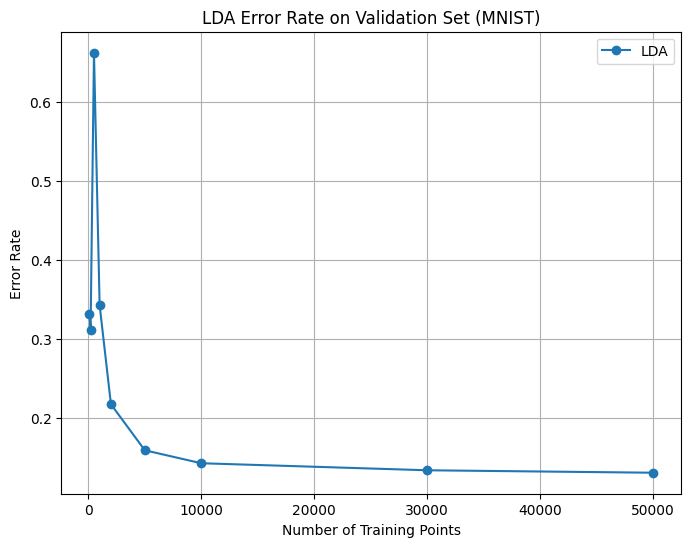

In [17]:
#part3
random.seed(189)
np.random.seed(189)

mnist_data = np.load("../data/mnist-data-hw3.npz")

mnist_validation_data, mnist_validation_labels, mnist_training_data, mnist_training_labels = shuffle_partition_MNIST(mnist_data)
print("after process") 
print("MNIST Training Data Shape:", mnist_training_data.shape)
print("MNIST Validation Data Shape:", mnist_validation_data.shape)

subset_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates = []
for size in subset_sizes:

    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]

    pi_c, mu_c, Sigma, classes = train_lda(X_sub, y_sub)
    y_val_pred = predict_lda(mnist_validation_data, pi_c, mu_c, Sigma, classes)

    accuracy = np.mean(y_val_pred == mnist_validation_labels)
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)
    
    print(f"Training size={size}, Error Rate={error_rate:.4f}")
    
plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='LDA')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("LDA Error Rate on Validation Set (MNIST)")
plt.legend()
plt.grid(True)
plt.show()


after process
MNIST Training Data Shape: (50000, 784)
MNIST Validation Data Shape: (10000, 784)
train
predict
Training size=100, Error Rate=0.9560
train
predict
Training size=200, Error Rate=0.9206
train
predict
Training size=500, Error Rate=0.7388
train
predict
Training size=1000, Error Rate=0.3901
train
predict
Training size=2000, Error Rate=0.3322
train
predict
Training size=5000, Error Rate=0.4596
train
predict
Training size=10000, Error Rate=0.2026
train
predict
Training size=30000, Error Rate=0.1563
train
predict
Training size=50000, Error Rate=0.1508


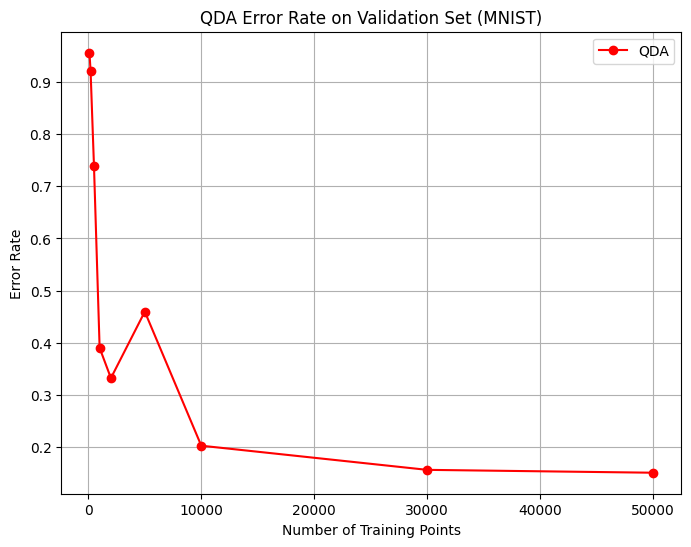

In [27]:
def train_qda(data, label):
    classes = np.unique(label)
    C = len(classes)
    n, d = data.shape

    pi_c = np.zeros(C)
    mu_c = np.zeros((C, d))
    Sigma_c = np.zeros((C, d, d))

    # Compute priors and means using vectorized NumPy operations
    for i, c in enumerate(classes):
        mask = (label == c)
        num_samples = data[mask]
        pi_c[i] = np.mean(mask)  # Equivalent to len(num_samples) / n
        mu_c[i] = np.mean(num_samples, axis=0)

        # Compute covariance matrix using vectorized operations
        diff = num_samples - mu_c[i]
        Sigma_c[i] = (diff.T @ diff) / (len(num_samples) - 1)  # Normalized covariance


    return pi_c, mu_c, Sigma_c, classes

def predict_qda(data, pi_c, mu_c, Sigma_c, classes):
    n, d = data.shape
    C = len(classes)
    scores = np.zeros((n, C))
    
    # For each class, compute its discriminant scores for all test samples.
    for c in range(C):
        # Compute the pseudo-inverse and determinant for class c
        Sigma_inv = np.linalg.pinv(Sigma_c[c])
        det_Sigma = np.linalg.det(Sigma_c[c])
        # Avoid log(0) issues:
        if det_Sigma <= 1e-10:
            det_Sigma = 1e-10
        log_det = np.log(det_Sigma)
        
        # Compute differences (data - mu_c) for class c
        diff = data - mu_c[c]  # shape: (n, d)
        # Compute quadratic term: for each sample, diff[i].T @ Sigma_inv @ diff[i]
        quad_form = np.sum((diff @ Sigma_inv) * diff, axis=1)
        
        # Compute the discriminant score for class c for all samples:
        # δ_c(x) = -0.5 * quad_form - 0.5 * log_det + log(pi_c[c])
        scores[:, c] = -0.5 * quad_form - 0.5 * log_det + np.log(pi_c[c])
    
    # For each sample, choose the class with the highest discriminant score.
    y_pred = np.array(classes)[np.argmax(scores, axis=1)]
    return y_pred


random.seed(189)
np.random.seed(189)
mnist_data = np.load("../data/mnist-data-hw3.npz")
mnist_validation_data, mnist_validation_labels, mnist_training_data, mnist_training_labels = shuffle_partition_MNIST(mnist_data)
print("after process") 
print("MNIST Training Data Shape:", mnist_training_data.shape)
print("MNIST Validation Data Shape:", mnist_validation_data.shape)

subset_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
error_rates = []
for size in subset_sizes:
    # Subset the training data
    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]

    # Train QDA
    pi_c, mu_c, Sigma_c, classes = train_qda(X_sub, y_sub)
    print("train")
    # Predict on validation set
    y_val_pred = predict_qda(mnist_validation_data, pi_c, mu_c, Sigma_c, classes)
    print("predict")
    # Compute error rate
    accuracy = np.mean(y_val_pred == mnist_validation_labels)
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)

    print(f"Training size={size}, Error Rate={error_rate:.4f}")

# Plot QDA error rate
plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='QDA', color='red')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("QDA Error Rate on Validation Set (MNIST)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import pandas as pd
def results_to_csv(y_test, file_name):
    y_test = y_test.astype(int)  
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  
    df.to_csv(file_name, index_label='Id')

In [ ]:
import numpy as np
import random
import pandas as pd

random.seed(189)
np.random.seed(189)

# Load MNIST dataset
mnist_data = np.load("../data/mnist-data-hw3.npz")

# Extract training and test data
X_train = mnist_data["training_data"].reshape(-1, 28 * 28)
y_train = mnist_data["training_labels"]
X_test = mnist_data["test_data"].reshape(-1, 28 * 28)  # Test set

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)

# Generate test set predictions
mnist_test_predictions = predict_lda(X_test, pi_c, mu_c, Sigma, classes)
# Save the predictions

results_to_csv(mnist_test_predictions, "mnist_submission_lda.csv")

print("LDA model trained on full dataset & predictions saved!")


Training Data Shape: (60000, 784)
Training Labels Shape: (60000,)
Test Data Shape: (10000, 784)
LDA model trained on full dataset & predictions saved!


In [37]:
%run featurize.py

SPAM Training Data Shape: (3337, 62)
SPAM Validation Data Shape: (834, 62)
Training size: 100 Class counts: [69 31]
Training size=100, Error Rate=0.2146
Training size: 200 Class counts: [135  65]
Training size=200, Error Rate=0.2098
Training size: 500 Class counts: [358 142]
Training size=500, Error Rate=0.1894
Training size: 1000 Class counts: [724 276]
Training size=1000, Error Rate=0.1906
Training size: 2000 Class counts: [1431  569]
Training size=2000, Error Rate=0.1942
Training size: 3337 Class counts: [2392  945]
Training size=3337, Error Rate=0.2134


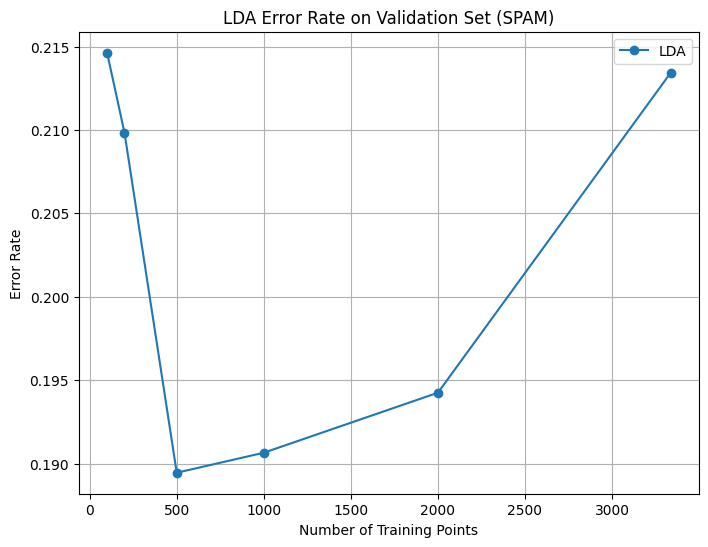

In [38]:
def shuffle_partition_SPAM(data):
    training_data = data["training_data"]
    training_labels = data["training_labels"].reshape(-1, 1)
    combined_data = np.hstack((training_data, training_labels))

    np.random.shuffle(combined_data)
    index = int(0.2 * len(combined_data))
    validation_data = combined_data[:index, :-1]
    validation_labels = combined_data[:index, -1]
    training_data = combined_data[index:, :-1]
    training_labels = combined_data[index:, -1]
    return validation_data, validation_labels, training_data, training_labels


random.seed(189)
np.random.seed(189)

spam_data = np.load("../data/new-spam-data.npz")
spam_validation_data, spam_validation_labels, spam_training_data, spam_training_labels = shuffle_partition_SPAM(spam_data)  
print("SPAM Training Data Shape:", spam_training_data.shape)
print("SPAM Validation Data Shape:", spam_validation_data.shape) 

subset_sizes = [100, 200, 500, 1000, 2000, len(spam_training_data)]
error_rates = []

for size in subset_sizes:
    X_sub = spam_training_data[:size]
    y_sub = spam_training_labels[:size].flatten()

    print("Training size:", size, "Class counts:", np.bincount(y_sub.astype(int)))

    # Train LDA
    pi_c, mu_c, Sigma, classes = train_lda(X_sub, y_sub)

    # Predict on validation set
    y_val_pred = predict_lda(spam_validation_data, pi_c, mu_c, Sigma, classes)

    # Compute error rate
    accuracy = np.mean(y_val_pred == spam_validation_labels.flatten())
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)

    print(f"Training size={size}, Error Rate={error_rate:.4f}")

plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='LDA')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("LDA Error Rate on Validation Set (SPAM)")
plt.legend()
plt.grid(True)
plt.show()


SPAM Training Data Shape: (3337, 62)
SPAM Validation Data Shape: (834, 62)
Training size: 100 Class counts: [69 31]
Training size=100, Error Rate=0.2590
Training size: 200 Class counts: [135  65]
Training size=200, Error Rate=0.2122
Training size: 500 Class counts: [358 142]
Training size=500, Error Rate=0.2074
Training size: 1000 Class counts: [724 276]
Training size=1000, Error Rate=0.1894
Training size: 2000 Class counts: [1431  569]
Training size=2000, Error Rate=0.1882
Training size: 3337 Class counts: [2392  945]
Training size=3337, Error Rate=0.1811


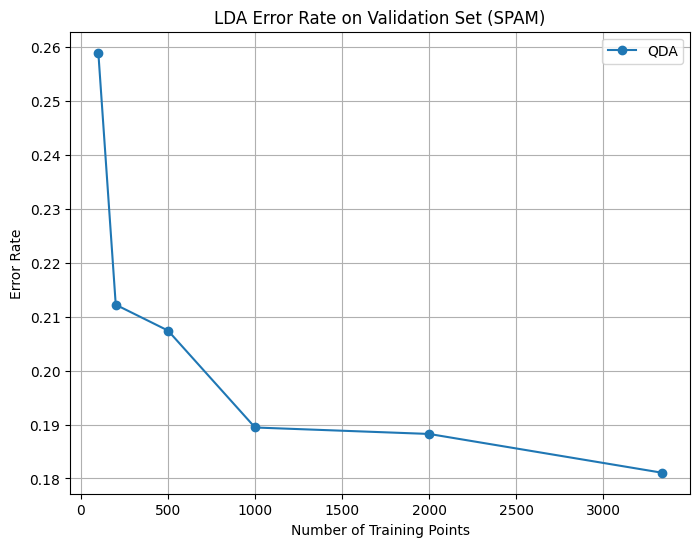

In [ ]:
random.seed(189)
np.random.seed(189)

spam_data = np.load("../data/new-spam-data.npz")
spam_validation_data, spam_validation_labels, spam_training_data, spam_training_labels = shuffle_partition_SPAM(spam_data)  
print("SPAM Training Data Shape:", spam_training_data.shape)
print("SPAM Validation Data Shape:", spam_validation_data.shape) 

subset_sizes = [100, 200, 500, 1000, 2000, len(spam_training_data)]
error_rates = []

for size in subset_sizes:
    X_sub = spam_training_data[:size]
    y_sub = spam_training_labels[:size].flatten()

    print("Training size:", size, "Class counts:", np.bincount(y_sub.astype(int)))

    # Train LDA
    pi_c, mu_c, Sigma, classes = train_qda(X_sub, y_sub)

    # Predict on validation set
    y_val_pred = predict_qda(spam_validation_data, pi_c, mu_c, Sigma, classes)

    # Compute error rate
    accuracy = np.mean(y_val_pred == spam_validation_labels.flatten())
    error_rate = 1.0 - accuracy
    error_rates.append(error_rate)

    print(f"Training size={size}, Error Rate={error_rate:.4f}")

plt.figure(figsize=(8,6))
plt.plot(subset_sizes, error_rates, marker='o', label='QDA')
plt.xlabel("Number of Training Points")
plt.ylabel("Error Rate")
plt.title("QDA Error Rate on Validation Set (SPAM)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
import numpy as np
import pandas as pd

# Load SPAM dataset
spam_data = np.load("../data/new-spam-data.npz")
training_data = spam_data["training_data"]
training_labels = spam_data["training_labels"]
test_data = spam_data["test_data"]  # Load test data for final predictions

print(f"Full Training Data Shape: {training_data.shape}, Labels Shape: {training_labels.shape}")
print(f"Test Data Shape: {test_data.shape}")

# Train LDA on the entire dataset
pi_c, mu_c, Sigma, classes = train_qda(training_data, training_labels)

# Predict on test data
test_predictions = predict_qda(test_data, pi_c, mu_c, Sigma, classes)

print(f"Test Predictions Shape: {test_predictions.shape}")
results_to_csv(test_predictions, "t2-spam_submission.csv")



Full Training Data Shape: (4171, 62), Labels Shape: (4171,)
Test Data Shape: (1000, 62)
Test Predictions Shape: (1000,)


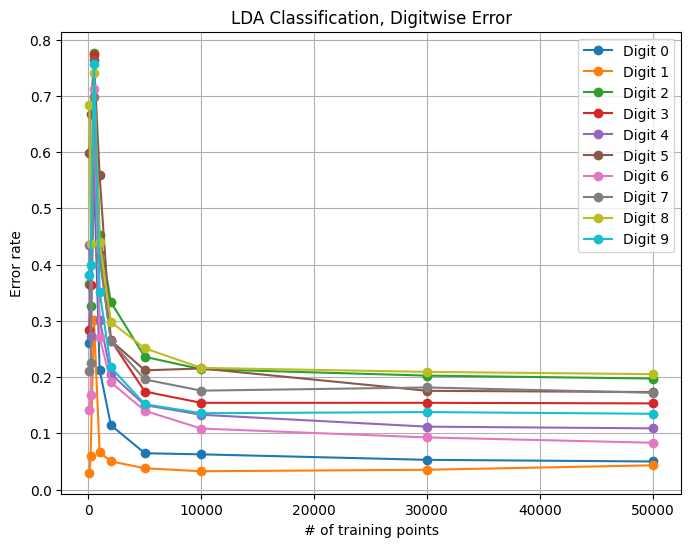

In [42]:
def compute_digitwise_error(y_val_true, y_val_pred):
    """
    Returns a 10-element array of error rates, one for each digit (0..9).
    error_rates[digit] = # misclassified samples of 'digit' / total samples of 'digit'
    """
    digit_errors = np.zeros(10)
    
    for digit in range(10):
        # Select samples of the given 'digit'
        mask = (y_val_true == digit)
        num_samples_digit = np.sum(mask)
        if num_samples_digit == 0:
            # If no samples of this digit are in validation set, skip or set error to 0
            digit_errors[digit] = 0
        else:
            # Count how many of these samples are misclassified
            misclassified = np.sum(y_val_pred[mask] != digit)
            digit_errors[digit] = misclassified / float(num_samples_digit)
    
    return digit_errors  # shape (10,)

subset_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

lda_digitwise_errs = []  # will hold arrays of shape (10,) for each subset size
for size in subset_sizes:
    # 1) Subset training data
    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]
    
    # 2) Train LDA 
    pi_c, mu_c, Sigma, classes = train_lda(X_sub, y_sub)
    
    # 3) Predict on validation set
    y_val_pred = predict_lda(mnist_validation_data, pi_c, mu_c, Sigma, classes)

    # 4) Compute digit‐wise error
    digit_err = compute_digitwise_error(mnist_validation_labels, y_val_pred)
    lda_digitwise_errs.append(digit_err)

# convert to NumPy array for easier slicing => shape (len(subset_sizes), 10)
lda_digitwise_errs = np.array(lda_digitwise_errs)  


qda_digitwise_errs = []
for size in subset_sizes:
    X_sub = mnist_training_data[:size]
    y_sub = mnist_training_labels[:size]
    
    # 2) Train LDA 
    pi_c, mu_c, Sigma, classes = train_qda(X_sub, y_sub)
    
    # 3) Predict on validation set
    y_val_pred_qda = predict_qda(mnist_validation_data, pi_c, mu_c, Sigma, classes)
    # train_qda, predict_qda
    digit_err = compute_digitwise_error(mnist_validation_labels, y_val_pred_qda)
    qda_digitwise_errs.append(digit_err)

qda_digitwise_errs = np.array(qda_digitwise_errs)  # shape (len(subset_sizes), 10)

plt.figure(figsize=(8,6))

# lda_digitwise_errs has shape (len(subset_sizes), 10),
# so lda_digitwise_errs[:, digit] gives the error rate curve for that digit.
for digit in range(10):
    plt.plot(subset_sizes, lda_digitwise_errs[:, digit], marker='o', label=f"Digit {digit}" if digit==0 else "")

plt.title("LDA Classification, Digitwise Error")
plt.xlabel("# of training points")
plt.ylabel("Error rate")
plt.grid(True)
# Create one legend entry per line (10 digits). In this sample, we only label the first line,
# so let’s fix that to have a single combined legend:
plt.legend([f"Digit {d}" for d in range(10)], loc="best")
plt.show()